# EDA (exploratory data analysis) of Zalando Research Fashion MNIST
[more](https://github.com/hyzhak/zalando-research-fashionmnist-experiments)

In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
DATASET_PATH = '../data/raw/zalando-fashionmnist/'
random_seed = 654321
img_width = 28
img_height = 28

In [3]:
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
!ls -lah $DATASET_PATH

total 201M
drwxrwxr-x  2 1000 1000 4.0K Jun 11 10:49 .
drwxrwxrwx 26 root root 4.0K Jun 11 09:10 ..
-rw-rw-r--  1 1000 1000  22M Dec  6  2017 fashion-mnist_test.csv
-rw-rw-r--  1 1000 1000 127M Dec  6  2017 fashion-mnist_train.csv
-rw-rw-r--  1 1000 1000 7.5M Dec  6  2017 t10k-images-idx3-ubyte
-rw-rw-r--  1 1000 1000 9.8K Dec  6  2017 t10k-labels-idx1-ubyte
-rw-rw-r--  1 1000 1000  45M Dec  6  2017 train-images-idx3-ubyte
-rw-rw-r--  1 1000 1000  59K Dec  6  2017 train-labels-idx1-ubyte


## Load data

we have dataset of images in different formats

### CSV

Original dataset (`*-ubyte`) was converted to CSV with this script: https://pjreddie.com/projects/mnist-in-csv/

I use casting to `int16` because we have only number which could be pack to a single byte ($0< x < 256$). by default read_csv will use `int64` (4 times bigger than we need)

In [5]:
%%time
train_df = pd.read_csv(f'{DATASET_PATH}/fashion-mnist_train.csv', dtype=np.int16)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int16(785)
memory usage: 89.8 MB
CPU times: user 3.32 s, sys: 99.7 ms, total: 3.42 s
Wall time: 3.42 s


In [6]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
%%time
test_df = pd.read_csv(f'{DATASET_PATH}/fashion-mnist_test.csv', dtype=np.int16)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 785 entries, label to pixel784
dtypes: int16(785)
memory usage: 15.0 MB
CPU times: user 601 ms, sys: 12 ms, total: 613 ms
Wall time: 613 ms


In [8]:
test_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Features

### "Label" feature
we have only one target features "label", all the rest just image pixels

we have balanced dataset, each label has 6k samples

In [9]:
train_df.groupby('label').size()

label
0    6000
1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
7    6000
8    6000
9    6000
dtype: int64

the same balance in test set. Each category has 1k samples

In [10]:
test_df.groupby('label').size()

label
0    1000
1    1000
2    1000
3    1000
4    1000
5    1000
6    1000
7    1000
8    1000
9    1000
dtype: int64

In [11]:
label_titles = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
]

### Images

lets plot few train samples

# TODO: put methods to /visualization lib

CPU times: user 391 ms, sys: 7.85 ms, total: 399 ms
Wall time: 397 ms


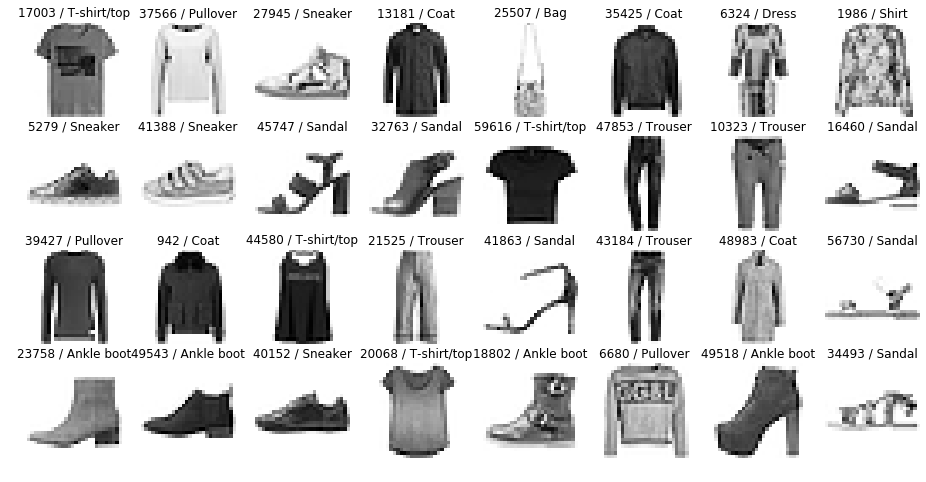

In [12]:
%%time

def get_image_values(df, row):
    image_df = row[df.columns[df.columns.str.contains('pixel')]]
    return image_df.values.reshape(img_width, img_height)

def plot_images(ax, df):
    for idx, (index, row) in enumerate(df.iterrows()):
        axis = ax[idx//ax.shape[1], idx%ax.shape[1]]
        image_values = get_image_values(df, row)
        label = row['label']
        axis.imshow(image_values, cmap=cm.Greys)
        axis.set_title(f'{index} / {label_titles[label]}')
        axis.axis('off')

fig, ax = plt.subplots(4, 8, figsize=(16, 8))
plot_images(ax, train_df.sample(4*8, random_state=random_seed))

and also test images

CPU times: user 418 ms, sys: 4.21 ms, total: 423 ms
Wall time: 421 ms


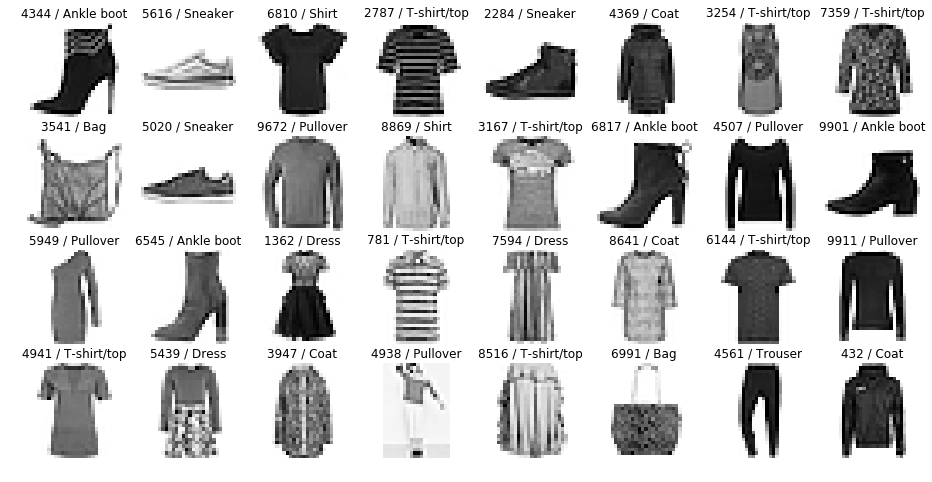

In [13]:
%%time

fig, ax = plt.subplots(4, 8, figsize=(16, 8))
plot_images(ax, test_df.sample(4*8, random_state=random_seed))